In [1]:
import pandas as pd
import numpy as np
import yaml
import sys

sys.path.append('../../')
from dataset import PdaVideos, collate_video
import transforms as my_transforms
from train_pda_cv import evaluate, compute_metrics

import models
import timm
import copy
import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

In [2]:
plt.rcParams['font.size'] = 14

In [3]:
# artifact_folder = "/project/dane2/wficai/pda/model_run_artifacts/pda_cvtest/"
artifact_folder = '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/'
frame_csv = '/project/dane2/wficai/pda/external_validation/Boston/frames/boston_frames.csv'
ground_truth = 'data_resources/ground_truth_pda.csv'

split = 'TEST' # 'TEST' or 'VAL' or None. None means val and test set.
CHOC_sensitivity = 0.76 # VAL and TEST happen to be the same

# load config.yaml from the artifact folder
with open(f'{artifact_folder}/config.yaml', 'r') as file:
    config = yaml.safe_load(file)

config['frame_csv'] = frame_csv
config['dataset_kwargs']['mode_filter'] = None
config['dataset_kwargs']['view_filter'] = None
config['dataset_kwargs']['split'] = split

device = torch.device('cuda:0')

In [4]:
config

{'artifact_folder': '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/',
 'dataloader_kwargs': {'batch_size': 15,
  'num_workers': 20,
  'pin_memory': True},
 'dataset_kwargs': {'mode_filter': None, 'view_filter': None, 'split': 'TEST'},
 'device': 'cuda:0',
 'early_stopper_kwargs': {'patience': 10},
 'encoder_kwargs': {'checkpoint': None,
  'checkpoint_path': None,
  'in_chans': 3,
  'model_name': 'resnet50d',
  'pretrained': True},
 'frame_csv': '/project/dane2/wficai/pda/external_validation/Boston/frames/boston_frames.csv',
 'num_epochs': 50,
 'optim_kwargs': {'lr': 0.0001, 'weight_decay': 0.001},
 'res': 112,
 'sched_kwargs': {'factor': 0.1, 'patience': 3, 'verbose': True},
 'subset_column': None,
 'time_downsample_kwargs': {'method': 'random', 'num_frames': 32},
 'vidnet_kwargs': {'drop_rate': 0.5,
  'num_heads': 4,
  'num_out': 1,
  'pooling_method': 'attn'}}

In [5]:
# use glob to get all *.ckpt files from the artifact directory
import glob
ckpt_files = glob.glob(f'{artifact_folder}/*.ckpt')
ckpt_files

['/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_0.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_1.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_10.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_11.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_2.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_3.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_4.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_5.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_6.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_checkpoint_video_7.ckpt',
 '/project/dane2/wficai/pda/model_run_artifacts/pda_ensemble/model_c

In [6]:
def create_model(checkpoint):
    # create the model
    encoder = timm.create_model(**config['encoder_kwargs'], num_classes=0)
    m = models.MedVidNet(copy.deepcopy(encoder), **config['vidnet_kwargs']).to(device)
    m.load_state_dict(torch.load(checkpoint, map_location=device))
    
    return m

model_list = torch.nn.ModuleList([create_model(ckpt) for ckpt in ckpt_files])

# define a pytorch model that takes the outputs from all of the models and averages them
class EnsembleModel(torch.nn.Module):
    def __init__(self, models):
        super().__init__()
        self.models = models
        
    def forward(self, x, num_frames):
        # [0] drops unneeded attention
        outputs = [m(x, num_frames)[0] for m in self.models]
        # none is for compatibility with the evaluate function
        return torch.mean(torch.stack(outputs), dim=0), None
    
ensemble_model = EnsembleModel(model_list).to(device)

In [7]:
# transforms
tfms = my_transforms.VideoTransforms(config['res'], time_downsample_kwargs = config['time_downsample_kwargs'])
tfms_test = tfms.get_transforms('test')

In [8]:
# load data
df_frames = pd.read_csv(config['frame_csv'])

# filter to "VAL" and "TEST" splits
df_frames = df_frames[df_frames['Split'].isin(['VAL', 'TEST'])]

# add dummy columns
df_frames['view'] = 'pdaView'
df_frames['mode'] = 'color'
df_frames['study'] = df_frames['study_id']
df_frames['patient_id'] = df_frames['study_id'] # pretend
df_frames['external_id'] = df_frames['clip_id']
df_frames['cv_split'] = 0

# create dataset
dat = PdaVideos(df_frames, transforms=tfms_test, **config['dataset_kwargs'])
print("Train data size:", len(dat))

Train data size: 294


In [9]:
dl_val= DataLoader(dat, collate_fn=collate_video, **config['dataloader_kwargs'])

In [10]:
loss, mets, targets, outputs, external_ids, patient_ids = evaluate(ensemble_model, dl_val, device)

# Clip-level metrics

In [11]:
mets

{'roc_auc': 0.8317362428842505,
 'accuracy': 0.7142857142857143,
 'sensitivity': 0.8764705882352941,
 'specificity': 0.49193548387096775}

Threshold: 0.436


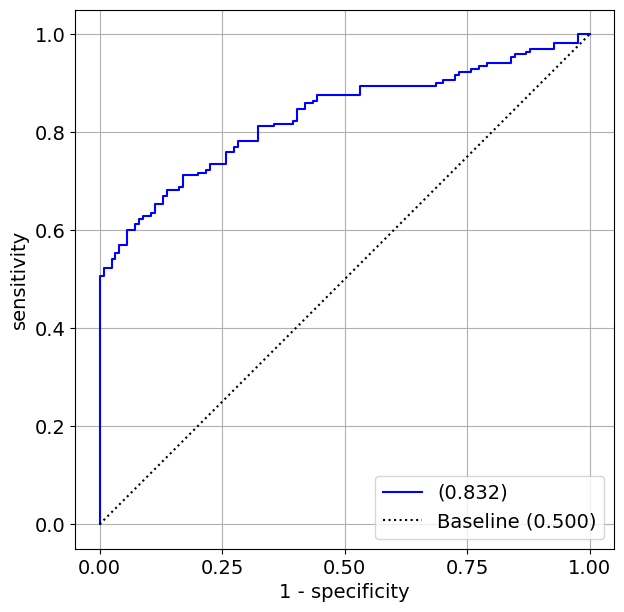

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# create a roc curve
grid = np.linspace(0, 1, 100)
fpr, tpr, eps = roc_curve(targets.astype(int), outputs)
score = roc_auc_score(targets.astype(int), outputs)

# find the threshold such that sensitivity ~= Choc value of 0.76 (validation set)
idx = np.argmin(np.abs(tpr - CHOC_sensitivity))
decision_threshold = eps[idx]
print(f"Threshold: {decision_threshold:0.3f}")

plt.plot(fpr, tpr, 'b-', label=f"({score:0.3f})")
plt.plot(grid, grid, 'k:', label='Baseline (0.500)')
plt.gca().set_aspect(1)
plt.legend(loc=4)
plt.grid()

plt.xlabel("1 - specificity")
plt.ylabel("sensitivity")

plt.gcf().set_size_inches(7,7)
plt.rcParams['font.size'] = 22

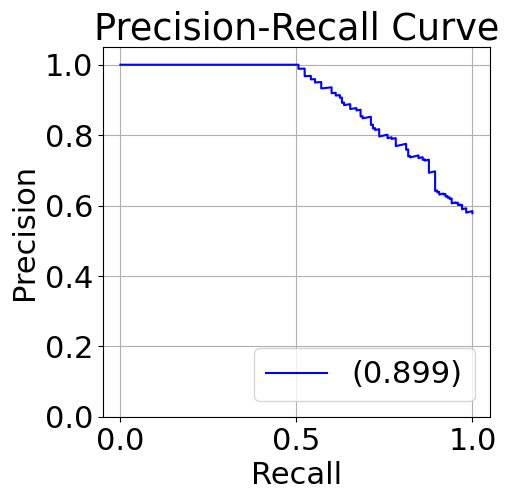

In [13]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# create a prec-rec curve
precision, recall, thresholds = precision_recall_curve(targets.astype(int), outputs)
ap = average_precision_score(targets.astype(int), outputs)

plt.plot(recall, precision, 'b-', label=f"({ap:0.3f})")
plt.ylim(0,1.05)
plt.gca().set_aspect(1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc=4)
plt.show()


In [14]:
# sensitivity and specificity at max f1
from sklearn.metrics import confusion_matrix
y_pred = outputs >= decision_threshold
y_true = targets.astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() 

sensitivity = tp / (tp + fn) # true positives / positives
specificity = tn / (tn + fp) # true negatives / negatives
ppv = tp / (tp + fp) # true positives / predicted positives
npv = tn / (tn + fn) # true negatives / predicted negatives

sensitivity, specificity, ppv, npv


(0.7588235294117647,
 0.7419354838709677,
 0.8012422360248447,
 0.6917293233082706)

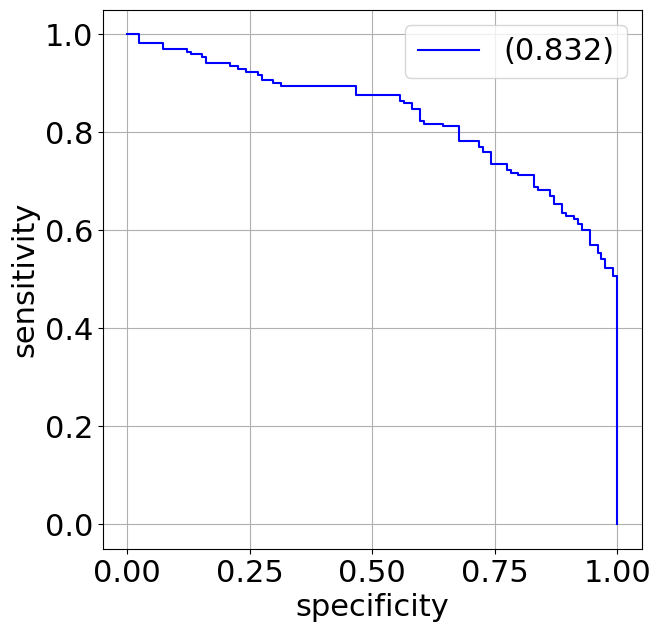

In [15]:
# sensitivity vs. specificity
grid = np.linspace(0, 1, 100)
fpr, tpr, eps = roc_curve(targets.astype(int), outputs)
score = roc_auc_score(targets.astype(int), outputs)

plt.plot(1-fpr, tpr, 'b-', label=f"({score:0.3f})")
plt.gca().set_aspect(1)
plt.legend(loc=1)
plt.grid()

plt.xlabel("specificity")
plt.ylabel("sensitivity")

plt.gcf().set_size_inches(7,7)
plt.rcParams['font.size'] = 22

# True positives and false negatives

In [16]:
def sigmoid(x): return 1/(1+np.exp(-x))

In [17]:
external_ids.shape, targets.shape, outputs.shape

((294,), (294,), (294, 1))

In [18]:
print("Decision threshold:", sigmoid(decision_threshold))
df_pred = pd.DataFrame({
    'external_id': external_ids, 
    'patient_id': patient_ids,
    'actual_pda': targets.astype(bool), 
    'pred_pda': outputs.squeeze()>decision_threshold,
    'confidence': sigmoid(outputs.squeeze()),   
    })

Decision threshold: 0.6072411726370874


In [19]:
df_pred

,external_id,patient_id,actual_pda,pred_pda,confidence
0,1_102_1.2.840.85458994400069811464357653232227,1.2.840.85458994400069811464357653232227,True,True,0.636386
1,1_103_1.2.840.85458994400069811464357653232227,1.2.840.85458994400069811464357653232227,True,True,0.685494
2,1_104_1.2.840.24572707487245121949231819213812,1.2.840.24572707487245121949231819213812,False,False,0.486905
3,1_105_1.2.840.12724871410466016279326760069581,1.2.840.12724871410466016279326760069581,True,True,0.894657
4,1_106_1.2.840.24572707487245121949231819213812,1.2.840.24572707487245121949231819213812,False,False,0.596054
...,...,...,...,...,...
289,1_9_1.2.840.44063381437939352694815914239252,1.2.840.44063381437939352694815914239252,True,True,0.995257
290,1_9_1.2.840.51592833316565973620574718603137,1.2.840.51592833316565973620574718603137,True,True,0.998778
291,1_9_1.2.840.61661772429118465397259870943830,1.2.840.61661772429118465397259870943830,True,True,0.927635
292,1_9_1.2.840.80580020752436168694813182645276,1.2.840.80580020752436168694813182645276,True,True,0.877056


In [20]:
false_ix = df_pred.actual_pda != df_pred.pred_pda
false_ix.sum()

74

In [21]:
df_false = df_pred[false_ix]

df_false['error_type'] = df_false.actual_pda.apply(lambda x: "False Negative" if x else "False Positive")

df_false

,external_id,patient_id,actual_pda,pred_pda,confidence,error_type
7,1_10_1.2.840.47545580993834576376077111907857,1.2.840.47545580993834576376077111907857,True,False,0.399123,False Negative
8,1_10_1.2.840.68432858919318425899371419989886,1.2.840.68432858919318425899371419989886,True,False,0.443475,False Negative
10,1_10_1.2.840.87814992980701538212818673097911,1.2.840.87814992980701538212818673097911,False,True,0.727686,False Positive
11,1_10_1.2.840.98921074339837249031704716302598,1.2.840.98921074339837249031704716302598,True,False,0.511845,False Negative
24,1_116_1.2.840.24572707487245121949231819213812,1.2.840.24572707487245121949231819213812,False,True,0.696809,False Positive
...,...,...,...,...,...,...
268,1_8_1.2.840.10832512476824362616598371874706,1.2.840.10832512476824362616598371874706,True,False,0.531356,False Negative
270,1_8_1.2.840.12659387360726375267236143825160,1.2.840.12659387360726375267236143825160,False,True,0.615371,False Positive
273,1_8_1.2.840.82630140060362944619136763158736,1.2.840.82630140060362944619136763158736,True,False,0.591732,False Negative
276,1_93_1.2.840.34648738439652014282636575613464,1.2.840.34648738439652014282636575613464,True,False,0.598124,False Negative


In [22]:
# merge on the view data
df_gt = pd.read_csv(ground_truth)[['global_key', 'anatomical_view', 'imaging_modality']]
df_gt = df_gt.rename({'global_key': 'external_id'}, axis=1)
df_false_expanded = df_false.merge(df_gt)
df_false_expanded.to_csv('data_resources/false_cases.csv', index=None)
df_false_expanded

,external_id,patient_id,actual_pda,pred_pda,confidence,error_type,anatomical_view,imaging_modality
0,1_10_1.2.840.47545580993834576376077111907857,1.2.840.47545580993834576376077111907857,True,False,0.399123,False Negative,pda_related_view,color_doppler
1,1_10_1.2.840.68432858919318425899371419989886,1.2.840.68432858919318425899371419989886,True,False,0.443475,False Negative,pda_related_view,color_compare
2,1_10_1.2.840.87814992980701538212818673097911,1.2.840.87814992980701538212818673097911,False,True,0.727686,False Positive,pda_related_view,color_compare
3,1_10_1.2.840.98921074339837249031704716302598,1.2.840.98921074339837249031704716302598,True,False,0.511845,False Negative,pda_view,color_doppler
4,1_116_1.2.840.24572707487245121949231819213812,1.2.840.24572707487245121949231819213812,False,True,0.696809,False Positive,pda_view,color_compare
...,...,...,...,...,...,...,...,...
69,1_8_1.2.840.10832512476824362616598371874706,1.2.840.10832512476824362616598371874706,True,False,0.531356,False Negative,pda_view,color_doppler
70,1_8_1.2.840.12659387360726375267236143825160,1.2.840.12659387360726375267236143825160,False,True,0.615371,False Positive,pda_view,color_compare
71,1_8_1.2.840.82630140060362944619136763158736,1.2.840.82630140060362944619136763158736,True,False,0.591732,False Negative,pda_related_view,color_compare
72,1_93_1.2.840.34648738439652014282636575613464,1.2.840.34648738439652014282636575613464,True,False,0.598124,False Negative,pda_related_view,color_doppler


In [23]:
df_false_expanded.error_type.value_counts()

False Negative    42
False Positive    32
Name: error_type, dtype: int64

In [24]:
df_false_expanded.anatomical_view.value_counts()

pda_related_view    49
pda_view            25
Name: anatomical_view, dtype: int64

In [25]:
df_false_expanded.imaging_modality.value_counts()

color_compare    44
color_doppler    30
Name: imaging_modality, dtype: int64

Text(0, 0.5, 'count')

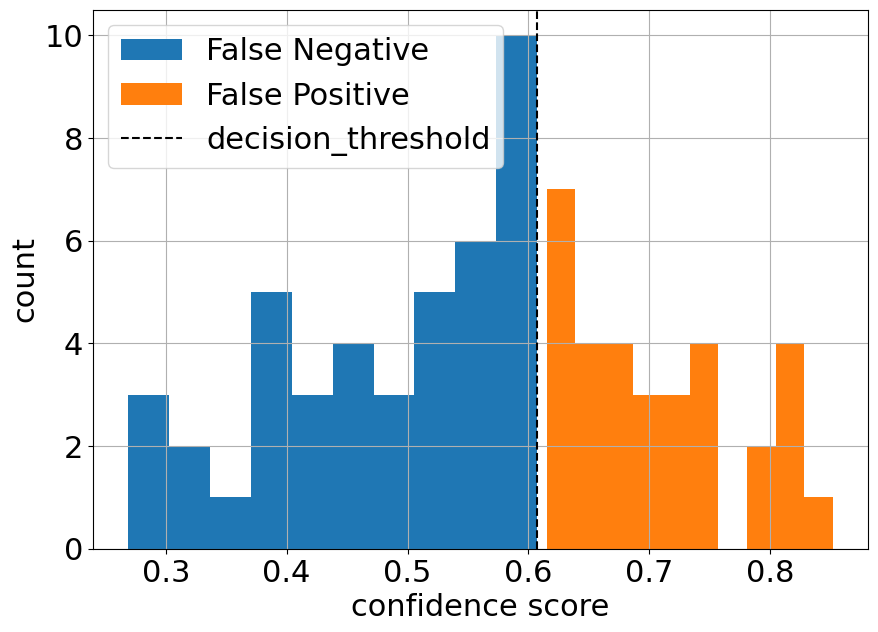

In [26]:
plt.gcf().set_size_inches(10,7)
for g, d in df_false.groupby('error_type'):
    d.confidence.hist(label=g)
plt.axvline(sigmoid(decision_threshold), color='k', linestyle='--', label='decision_threshold')
plt.legend()
plt.xlabel('confidence score')
plt.ylabel('count')


In [27]:
outputs.max()

7.060678005218506

In [28]:
sigmoid(decision_threshold)

0.6072411726370874

In [29]:
print("Decision threshold:", sigmoid(decision_threshold))
df_ls = []
for t in (0, 1):
    ix = targets==t
    num_cases = ix.sum()
    print("Negatives:" if t==0 else "Positives:", num_cases)
    ids = external_ids[ix]
    out = sigmoid(outputs[ix]).squeeze()
    decisions = out>sigmoid(decision_threshold)
    is_false = decisions if t==0 else ~decisions
    num_false = sum(is_false)
    print("Number False:", num_false)
    print("False rate:", num_false / num_cases)
    print("False external ids:")
    for idf in  ids[is_false]:
        print(idf)


Decision threshold: 0.6072411726370874
Negatives: 124
Number False: 32
False rate: 0.25806451612903225
False external ids:
1_10_1.2.840.87814992980701538212818673097911
1_116_1.2.840.24572707487245121949231819213812
1_117_1.2.840.24572707487245121949231819213812
1_11_1.2.840.11245322704992057048080338476223
1_11_1.2.840.21232668742653623323390679111689
1_132_1.2.840.59519430613589928298844279859441
1_135_1.2.840.59519430613589928298844279859441
1_13_1.2.840.82377253772686540611694484525308
1_153_1.2.840.11348449676493461455641392115705
1_154_1.2.840.11348449676493461455641392115705
1_155_1.2.840.11348449676493461455641392115705
1_16_1.2.840.97009864377393113384362716680817
1_17_1.2.840.11245322704992057048080338476223
1_29_1.2.840.13379230599199302669302351686872
1_2_1.2.840.35700542691673444453599837054291
1_2_1.2.840.38756472466251989709092621356293
1_30_1.2.840.13379230599199302669302351686872
1_31_1.2.840.13379230599199302669302351686872
1_33_1.2.840.1337923059919930266930235168687

# Study-level metrics

In [30]:
df_clip = pd.DataFrame({'study_id': patient_ids, 'targets': targets, 'outputs': outputs.squeeze()})

# take the average logits
df_study = df_clip.groupby('study_id', as_index=False).agg('mean')

targ = df_study.targets.values
out = df_study.outputs.values

In [31]:
compute_metrics(targ, out)

{'roc_auc': 0.852093023255814,
 'accuracy': 0.7205882352941176,
 'sensitivity': 0.9069767441860465,
 'specificity': 0.4}

Threshold: 0.579


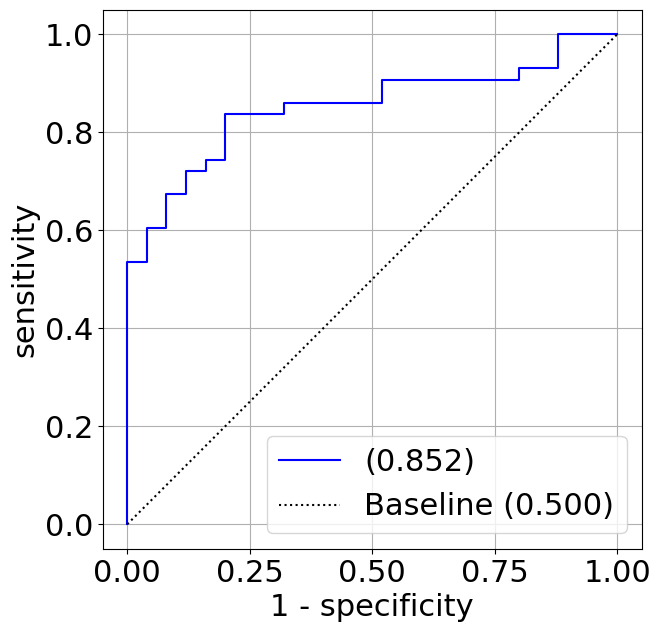

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# create a roc curve
grid = np.linspace(0, 1, 100)
fpr, tpr, eps = roc_curve(targ.astype(int), out)
score = roc_auc_score(targ.astype(int), out)

# find the threshold such that sensitivity ~= Choc value of 0.76 (validation set)
idx = np.argmin(np.abs(tpr - CHOC_sensitivity))
decision_threshold = eps[idx]
print(f"Threshold: {decision_threshold:0.3f}")

plt.plot(fpr, tpr, 'b-', label=f"({score:0.3f})")
plt.plot(grid, grid, 'k:', label='Baseline (0.500)')
plt.gca().set_aspect(1)
plt.legend(loc=4)
plt.grid()

plt.xlabel("1 - specificity")
plt.ylabel("sensitivity")

plt.gcf().set_size_inches(7,7)
plt.rcParams['font.size'] = 22

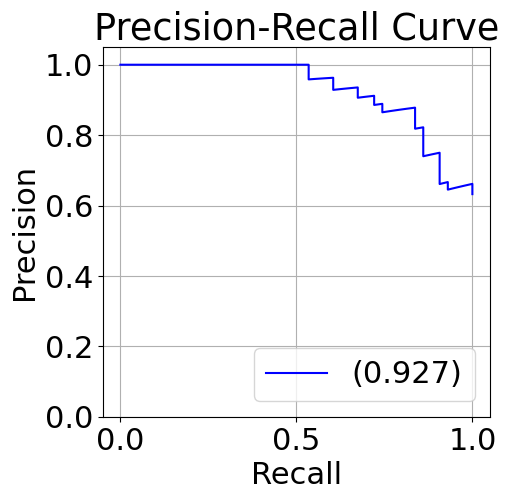

In [33]:
from sklearn.metrics import precision_recall_curve, average_precision_score
# create a prec-rec curve
precision, recall, thresholds = precision_recall_curve(targ.astype(int), out)
ap = average_precision_score(targ.astype(int), out)

plt.plot(recall, precision, 'b-', label=f"({ap:0.3f})")
plt.ylim(0,1.05)
plt.gca().set_aspect(1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.legend(loc=4)
plt.show()


In [34]:
# sensitivity and specificity at max f1
from sklearn.metrics import confusion_matrix
y_pred = out >= decision_threshold
y_true = targ.astype(int)
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel() 

sensitivity = tp / (tp + fn) # true positives / positives
specificity = tn / (tn + fp) # true negatives / negatives
ppv = tp / (tp + fp) # true positives / predicted positives
npv = tn / (tn + fn) # true negatives / predicted negatives

sensitivity, specificity, ppv, npv


(0.7441860465116279, 0.84, 0.8888888888888888, 0.65625)

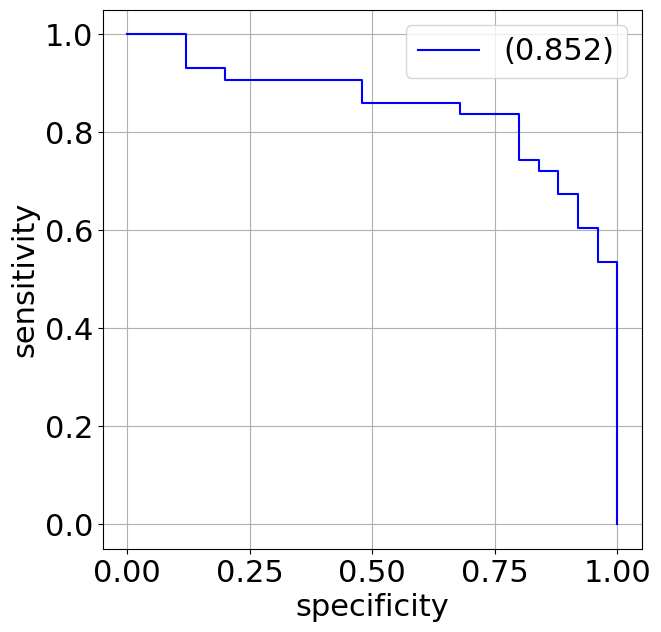

In [35]:
# sensitivity vs. specificity
grid = np.linspace(0, 1, 100)
fpr, tpr, eps = roc_curve(targ.astype(int), out)
score = roc_auc_score(targ.astype(int), out)

plt.plot(1-fpr, tpr, 'b-', label=f"({score:0.3f})")
plt.gca().set_aspect(1)
plt.legend(loc=1)
plt.grid()

plt.xlabel("specificity")
plt.ylabel("sensitivity")

plt.gcf().set_size_inches(7,7)
plt.rcParams['font.size'] = 22